In [1]:
using LinearAlgebra
using Printf
using Plots

cd("..")
using Pkg
Pkg.activate(".")
using SBP_operators

┌ Info: Precompiling SBP_operators [2a38a53b-f4bb-477b-bf52-089ecd1fc230]
└ @ Base loading.jl:1317


In [2]:
function rate(uₓₓ,u,n,Δx,Δt,k,t,x;order=2)
    # This one
    uₓₓ = Dₓₓ!(uₓₓ,u,k,n,Δx,order=order)
    return uₓₓ
end

function rate2(uₓₓ,u,n,Δx,Δt,k,t,x;order=2)
    # SAT version
    uₓₓ = Dₓₓ!(uₓₓ,u,k,n,Δx,order=order)

    SATₗ = SAT_left(:Dirichlet,u,Δx,g(t),c=k,order=order)
    SATᵣ = SAT_right(:Dirichlet,u,Δx,g(t),c=k,order=order)
    
    uₓₓ[1:order] += SATₗ
    uₓₓ[end-order+1:end] += SATᵣ

    return uₓₓ
end

rate2 (generic function with 1 method)

In [3]:
𝒟 = [0.0,1.0]
n = 51
Δx = 𝒟[2]/(n-1)
x = collect(range(𝒟[1],𝒟[2],step=Δx))

k = zeros(Float64,n) .+ 1.0

Δt = 0.1 * Δx^2
t_f = 100Δt
N = ceil(Int64,t_f/Δt)

u₀(x) = exp.(-(x.-0.5).^2 ./ 0.02)

g(t) = [0.0, 1.0]

order = 2

println("Δx=",Δx,"      ","Δt=",Δt,"        ","final time=",t_f)

Δx=0.02      Δt=4.0e-5        final time=0.004


In [4]:
u_s = zeros(Float64,length(x),N)
u_w = zeros(Float64,length(x),N)

u_s[:,1] = u₀(x);
u_w[:,1] = u₀(x);

In [5]:
function euler(u::Matrix,RHS::Function,n::Int64,Δx::Float64,x::Vector,Δt::Float64,t_f::Float64,k,g;order=2,strong=false)

    for i = 1:N-1
        t = i*Δt
        u[:,i+1] = u[:,i] + Δt*RHS(u[:,i+1],u[:,i],n,Δx,Δt,k,t,x,order=order)

        if strong
            u[1,i+1] = g(t)[1]
            u[end,i+1] = g(t)[end]
        end
    end

    return u
end

euler (generic function with 1 method)

In [6]:
u_s = euler(u_s,rate,n,Δx,x,Δt,t_f,k,g,order=order,strong=true);
u_w = euler(u_w,rate2,n,Δx,x,Δt,t_f,k,g,order=order);

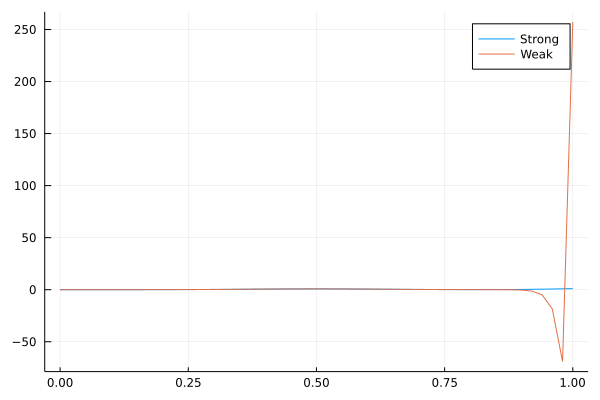

In [7]:
plot(x,u_s[:,end],label="Strong")
plot!(x,u_w[:,end],label="Weak")